# Compare MCMC with BBVI 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import liesel.goose as gs
import liesel.model as lsl
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate as LieselMultivariateNormalDegenerate
from liesel.goose.types import Array

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate as TigerpyMultivariateNormalDegenerate

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

In [2]:
import simulation.sim_fun.sim_data as sim_data

In [3]:
key = jax.random.PRNGKey(27)

In [4]:
n_obs = 10000
key, *subkeys = jax.random.split(key, 3)
x = jax.random.uniform(subkeys[0], shape=(n_obs,), minval=-3, maxval=3)

# linear predictors 
nu_1 = 0.5 + 0.5*x + 1.25*jnp.sin(1.5*x) 
nu_2 = 0.075 + 0.275*x
key, subkey = jax.random.split(key)
response_vec  = tfjd.Normal(loc=nu_1, scale=jnp.exp(nu_2)).sample(sample_shape=(), seed=subkey)

In [5]:
x_plot = jnp.linspace(-3, 3, num=500)
mean_plot = 0.5 + 0.5*(x_plot) + 1.25*jnp.sin(1.5*x_plot) 
sigma_plot = jnp.exp(0.075 + 0.275*x_plot)

In [6]:
data = pd.DataFrame({"x": x, "y": response_vec, "loc": nu_1, "scale": jnp.exp(nu_2)})
data = data.sort_values("x")

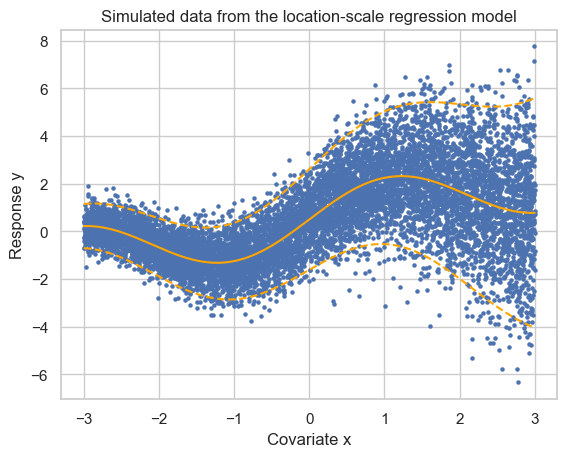

In [7]:
# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Plot the simulated data
plt.scatter(x, response_vec, s = 5)
plt.plot(x_plot, mean_plot, color="orange")
plt.plot(x_plot, mean_plot - 1.96*sigma_plot, color="orange", linestyle="--")
plt.plot(x_plot, mean_plot + 1.96*sigma_plot, color="orange", linestyle="--")
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Fit from BBVI

In [8]:
# Define a model with intercept 
# Set up design matrices
# Loc linear predictor
X = tiger.Obs(name="X", intercept=True)
X.smooth(data=x)
X.center()

# Scale linear predictor
Z = tiger.Obs(name="Z", intercept=True)
Z.fixed(data=x)

# Define the loc branch
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=jnp.zeros((1,)), distribution=beta_dist, name="beta")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau2_a = tiger.Hyper(1.0, name="tau2_a")
tau2_b = tiger.Hyper(0.00005, name="tau2_b")
tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau2_a, scale=tau2_b)
tau2 = tiger.Param(value=jnp.array([1.0]), distribution=tau2_dist, param_space="positive", name="tau2")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth1_loc = tiger.Hyper(jnp.zeros(X.smooth_dim_cent[0]), name="smooth1_loc")

# Define the penalty matrix 
smooth1_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="smooth1_pen")

# Set up parameters
smooth1_dist = tiger.Dist(TigerpyMultivariateNormalDegenerate, loc=smooth1_loc, var=tau2, pen=smooth1_pen)
smooth1 = tiger.Param(value=jnp.zeros(X.smooth_dim_cent[0]), distribution=smooth1_dist, name="smooth1")

# Set up the linear predictor for loc
lpred_loc = tiger.Lpred(obs=X, beta=beta, smooth1=smooth1)

# Define the scale branch
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(10.0, name="gamma_scale")

# Set up parameters
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=jnp.zeros((2,)), distribution=gamma_dist, name="gamma")

lpred_scale = tiger.Lpred(obs=Z, function=jnp.exp, gamma=gamma)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [9]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

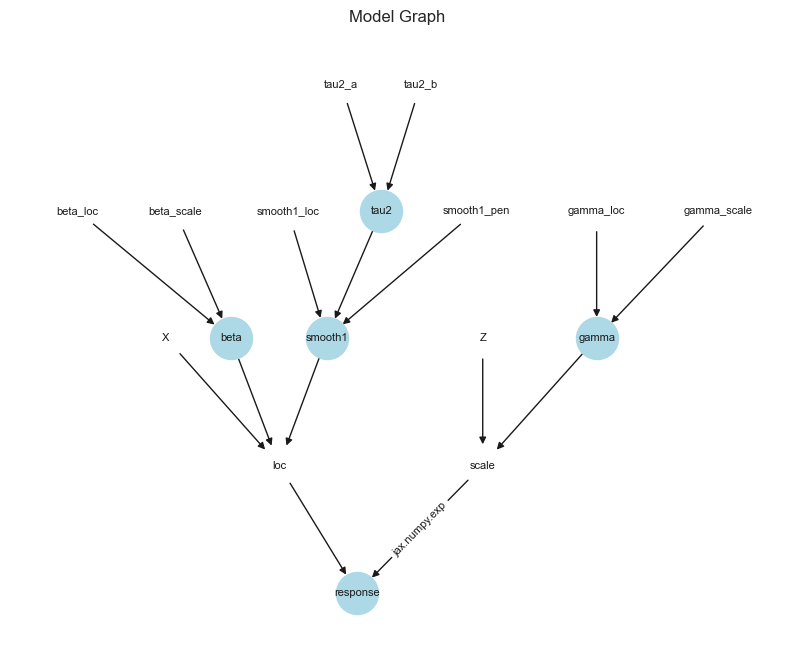

In [10]:
graph.visualize_graph()

In [21]:
q = bbvi.Bbvi(graph=graph, 
              loc_prec=2.0,
              scale_prec=5.0)

In [22]:
key, subkey = jax.random.split(key)
q.run_bbvi(key=subkey,
           learning_rate=0.01,
           grad_clip=1,
           threshold=1e-2,
           batch_size=256,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=50,
           epochs=250)

Start optimization ...
Finished optimization.


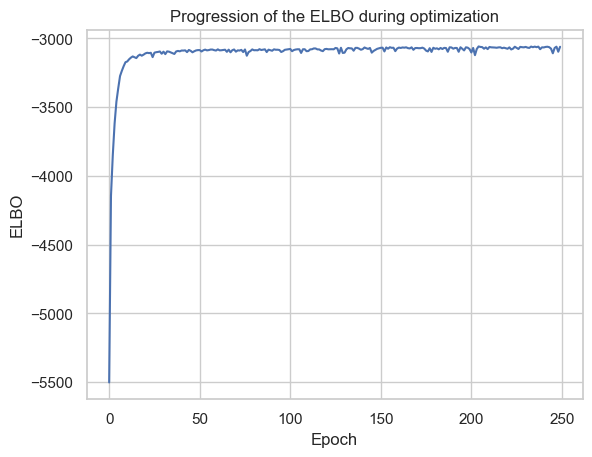

In [23]:
q.plot_elbo()

In [24]:
q.return_loc_params

{'beta': {'loc': Array([0.4927372], dtype=float32)},
 'tau2': {'loc': Array([0.03221947], dtype=float32)},
 'gamma': {'loc': Array([0.07460956, 0.26701406], dtype=float32)},
 'smooth1': {'loc': Array([-1.0376562 , -1.0422087 , -1.5959687 , -1.7495997 , -1.8280159 ,
         -1.6408622 , -1.356313  , -0.9325901 , -0.27474037,  0.3603594 ,
          0.9151003 ,  1.313791  ,  1.6588941 ,  1.8065054 ,  1.7888875 ,
          1.520319  ,  1.3628317 ,  0.66172034,  0.73542583], dtype=float32)}}

In [25]:
beta = q.trans_var_params["beta"]["loc"]
smooth1 = q.trans_var_params["smooth1"]["loc"]
gamma = q.trans_var_params["gamma"]["loc"]
loc_param = jnp.concatenate((beta, smooth1))
y_loc = X.design_matrix @ loc_param
y_scale = jnp.exp(Z.design_matrix @ gamma)

In [26]:
pred_data_tiger = pd.DataFrame({"x": x, "y_loc": y_loc, "y_scale": y_scale})
sort_pred_data_tiger = pred_data_tiger.sort_values("x")

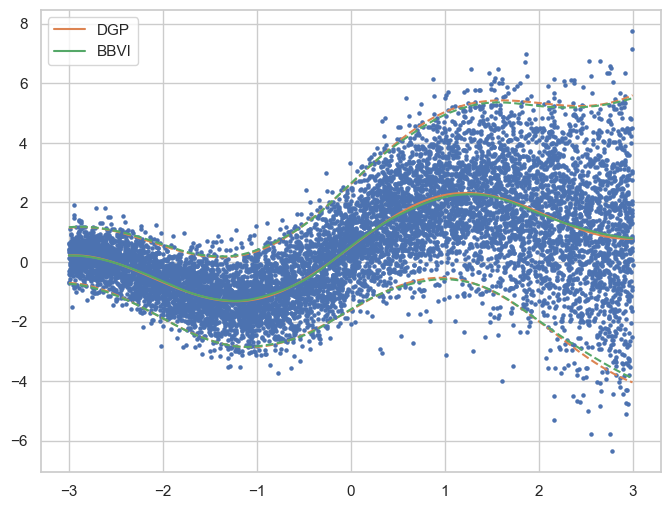

In [27]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=data["x"], y=data["y"], s=5)
plt.plot(data["x"], data["loc"], label="DGP", color=sns.color_palette()[1])
plt.plot(data["x"], data["loc"] + 1.96*data["scale"], color=sns.color_palette()[1], linestyle='dashed')
plt.plot(data["x"], data["loc"] - 1.96*data["scale"], color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"], color=sns.color_palette()[2], label = "BBVI")
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] + 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] - 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.legend()
plt.show()

sns.reset_orig()

## Fit from liesel

In [28]:
# Define Groups for the smooth parameter priors
class VarianceIG(lsl.Group):
    def __init__(
        self, name: str, a: float, b: float, start_value: float = 1000.0
    ) -> None:
        a_var = lsl.Var(a, name=f"{name}_a")
        b_var = lsl.Var(b, name=f"{name}_b")

        prior = lsl.Dist(tfjd.InverseGamma, concentration=a_var, scale=b_var)
        tau2 = lsl.param(start_value, distribution=prior, name=name)
        super().__init__(name=name, a=a_var, b=b_var, tau2=tau2)

class SplineCoef(lsl.Group):
    def __init__(self, name: str, penalty: Array, tau2: lsl.param) -> None:
        penalty_var = lsl.Var(penalty, name=f"{name}_penalty")

        evals = jax.numpy.linalg.eigvalsh(penalty)
        rank = lsl.Data(jnp.sum(evals > 0.0), _name=f"{name}_rank")
        _log_pdet = jnp.log(jnp.where(evals > 0.0, evals, 1.0)).sum()
        log_pdet = lsl.Data(_log_pdet, _name=f"{name}_log_pdet")

        prior = lsl.Dist(
            LieselMultivariateNormalDegenerate.from_penalty,
            loc=0.0,
            var=tau2,
            pen=penalty_var,
            rank=rank,
            log_pdet=log_pdet
        )
        start_value = np.zeros(np.shape(penalty)[-1], np.float32)

        coef = lsl.param(start_value, distribution=prior, name=name)

        super().__init__(name, coef=coef, penalty=penalty_var, tau2=tau2, rank=rank)

class PSpline(lsl.Group):
    def __init__(
        self, name, basis_matrix: Array, penalty: Array, tau2_group: lsl.Group
    ) -> None:
        coef_group = SplineCoef(
            name=f"{name}_coef", penalty=penalty, tau2=tau2_group["tau2"]
        )

        basis_matrix = lsl.obs(basis_matrix, name="basis_matrix")
        smooth = lsl.Var(
            lsl.Calc(jnp.dot, basis_matrix, coef_group["coef"]), name=name
        )

        group_vars = coef_group.nodes_and_vars | tau2_group.nodes_and_vars

        super().__init__(
            name=name,
            basis_matrix=basis_matrix,
            smooth=smooth,
            **group_vars
        )

In [29]:
# Set up model in liesel
# Loc branch 
# Fixed parameter prior
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

# Set up the fixed parameters
beta_dist = lsl.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = lsl.param(value=jnp.zeros((1,)), distribution=beta_dist, name="beta")

# Set up the smooth parameters
tau2_group = VarianceIG(name="tau2", a=1.0, b=0.00005)

penalty = X.smooth_pen_mat_cent[0]
smooth_group_1 = PSpline(name="smooth_1", basis_matrix=X.design_mat_cent[1], penalty=penalty, tau2_group=tau2_group)

X_liesel = lsl.obs(X.fixed_data, name="X")

loc_fn = lambda x, beta, smooth_1: jnp.dot(x, beta) + smooth_1
loc_calc = lsl.Calc(loc_fn, x=X_liesel, beta=beta, smooth_1=smooth_group_1["smooth"])

loc = lsl.Var(loc_calc, name="loc")

# Scale branch 
# Fixed parameter prior
gamma_loc = lsl.Var(0.0, name="gamma_loc")
gamma_scale = lsl.Var(10.0, name="gamma_scale")

# Set up the fixed parameters
gamma_dist = lsl.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = lsl.param(value=jnp.zeros((2,)), distribution=gamma_dist, name="gamma")

Z_liesel = lsl.obs(Z.fixed_data, name="Z")

lpred_scale_fn = lambda z, gamma: jnp.dot(z, gamma)
lpred_scale_calc = lsl.Calc(lpred_scale_fn, z=Z_liesel, gamma=gamma)
lpred_scale = lsl.Var(lpred_scale_calc, name="lpred_scale")

scale_fn = lambda s: jnp.exp(s)
scale_calc = lsl.Calc(scale_fn, s=lpred_scale)
scale = lsl.Var(scale_calc, name="scale")

response_dist = lsl.Dist(tfjd.Normal, loc=loc, scale=scale)
response = lsl.Var(response_vec, distribution=response_dist, name="response")

In [30]:
gb = lsl.GraphBuilder().add(response)

liesel.model.model - INFO - Converted dtype of Data(name="Z_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_1_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="X_value").value


In [31]:
model = gb.build_model()

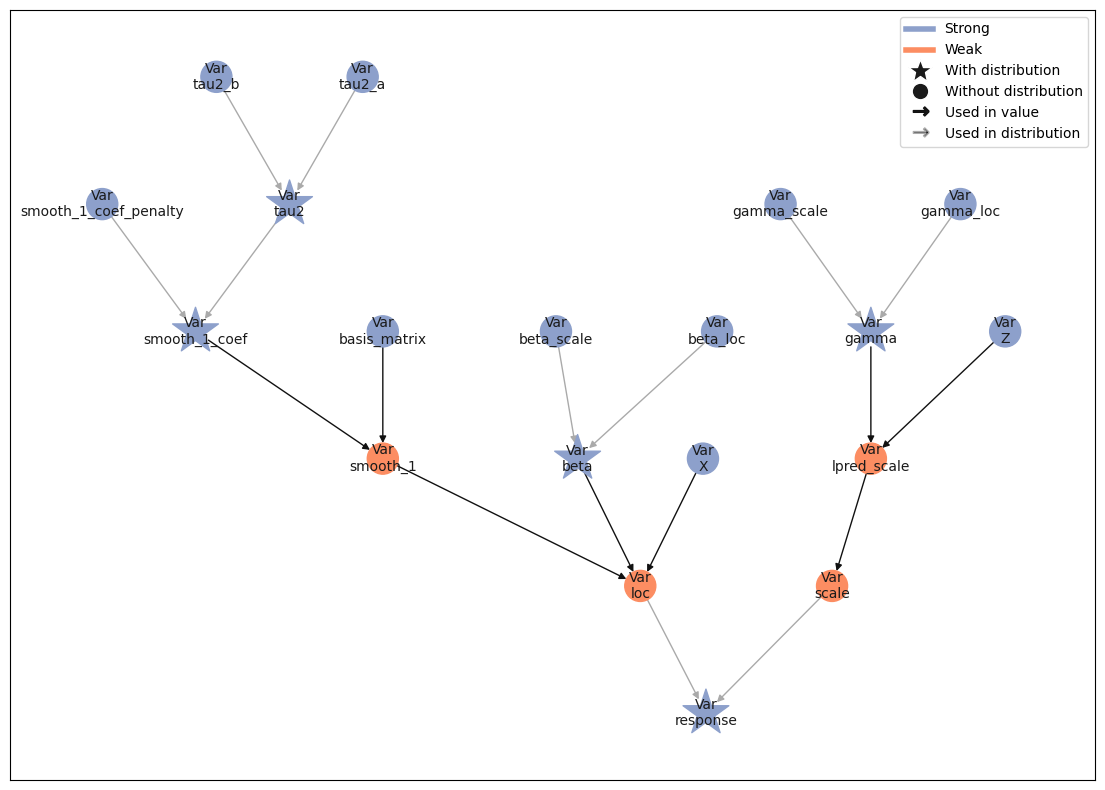

In [32]:
lsl.plot_vars(model)

In [33]:
def tau2_gibbs_kernel(p_spline: PSpline) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""
    position_key = p_spline["tau2"].name

    def transition(prng_key, model_state):
        a_prior = p_spline.value_from(model_state, "a")
        b_prior = p_spline.value_from(model_state, "b")

        rank = p_spline.value_from(model_state, "rank")
        K = p_spline.value_from(model_state, "penalty")

        beta = p_spline.value_from(model_state, "coef")

        a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
        b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {position_key: draw}

    return gs.GibbsKernel([position_key], transition)

In [43]:
key, subkey = jax.random.split(key)
builder = gs.EngineBuilder(seed=subkey, num_chains=4)

builder.set_model(gs.LieselInterface(model))
builder.set_initial_values(model.state)

builder.add_kernel(tau2_gibbs_kernel(smooth_group_1))
builder.add_kernel(gs.NUTSKernel(["beta"]))
builder.add_kernel(gs.NUTSKernel(["smooth_1_coef"]))
builder.add_kernel(gs.NUTSKernel(["gamma"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

engine = builder.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [44]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


liesel.goose.engine - WARNING - Errors per chain for kernel_01: 4, 3, 5, 4 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 9, 10, 6, 11 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 2, 2, 5, 3 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 1, 2 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 4, 2, 5, 5 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 2, 2, 1, 1 / 50 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 7, 6, 6,

In [41]:
results = engine.get_results()
gs.Summary(results)

Parameter summary:

                        kernel      mean        sd    q_0.05     q_0.5  \
parameter     index                                                      
beta          (0,)   kernel_01  0.487522  0.012916  0.466221  0.487283   
gamma         (0,)   kernel_03  0.074575  0.007196  0.062687  0.074717   
              (1,)   kernel_03  0.272817  0.004054  0.266156  0.272775   
smooth_1_coef (0,)   kernel_02 -1.032531  0.029866 -1.081010 -1.033135   
              (1,)   kernel_02 -1.072072  0.028565 -1.118241 -1.072419   
              (2,)   kernel_02 -1.568792  0.037328 -1.630074 -1.569491   
              (3,)   kernel_02 -1.769185  0.041922 -1.838033 -1.768818   
              (4,)   kernel_02 -1.837540  0.042750 -1.907839 -1.837349   
              (5,)   kernel_02 -1.671506  0.043304 -1.742551 -1.671258   
              (6,)   kernel_02 -1.392019  0.047155 -1.470606 -1.391693   
              (7,)   kernel_02 -0.933089  0.049068 -1.013440 -0.932442   
              (8,)   kernel_02 -0.301781  0.048771 -0.383808 -0.302000   
              (9,)   kernel_02  0.384369  0.050079  0.303250  0.383751   
              (10,)  kernel_02  0.971387  0.054176  0.883645  0.969872   
              (11,)  kernel_02  1.369119  0.056233  1.274557  1.369890   
              (12,)  kernel_02  1.683224  0.058069  1.588857  1.683359   
              (13,)  kernel_02  1.815416  0.059969  1.715543  1.814645   
              (14,)  kernel_02  1.786903  0.063119  1.682700  1.786491   
              (15,)  kernel_02  1.546769  0.064911  1.442336  1.547323   
              (16,)  kernel_02  1.450320  0.067615  1.340859  1.450546   
              (17,)  kernel_02  0.699682  0.055729  0.605846  0.700875   
              (18,)  kernel_02  0.642407  0.075568  0.517646  0.643096   
tau2          ()     kernel_00  0.027316  0.011973  0.014016  0.024696   

                       q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter     index                                                             
beta          (0,)   0.509295         4000   473.559452   794.657507  1.010367  
gamma         (0,)   0.086351         4000  1813.313751  1921.407866  1.003755  
              (1,)   0.279513         4000  4190.482178  3118.272901  1.000763  
smooth_1_coef (0,)  -0.983201         4000  1309.245265  1825.990166  1.002164  
              (1,)  -1.025042         4000  4114.115086  2930.406476  1.000730  
              (2,)  -1.509179         4000  3522.374227  2686.139983  1.001467  
              (3,)  -1.701124         4000  4662.990386  2704.364892  1.002251  
              (4,)  -1.767966         4000  3867.003089  2727.140869  1.000912  
              (5,)  -1.600531         4000  4210.874497  3055.708920  1.002243  
              (6,)  -1.314631         4000  4989.298234  2907.549169  1.002999  
              (7,)  -0.853808         4000  4893.893747  2568.297483  1.002419  
              (8,)  -0.222748         4000  5217.238051  3348.675913  1.000630  
              (9,)   0.469760         4000  4422.533407  2730.352863  1.000627  
              (10,)  1.063533         4000  4840.595231  3193.789479  1.001028  
              (11,)  1.460889         4000  4345.583877  2707.277284  0.999581  
              (12,)  1.779623         4000  4466.234967  3027.866362  1.000610  
              (13,)  1.914654         4000  3899.381736  3159.344707  1.000493  
              (14,)  1.890693         4000  3649.319359  2723.751082  1.000024  
              (15,)  1.653355         4000  3303.491144  2735.915062  0.999547  
              (16,)  1.563802         4000  1870.227996  2396.724669  1.001666  
              (17,)  0.789860         4000  1921.594528  2488.550899  1.001401  
              (18,)  0.765780         4000  2188.461526  2620.561209  1.002192  
tau2          ()     0.050320         4000  1613.192287  2397.979802  1.001933  

Error summary:

                                                    count relative
kernel    error_code

/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


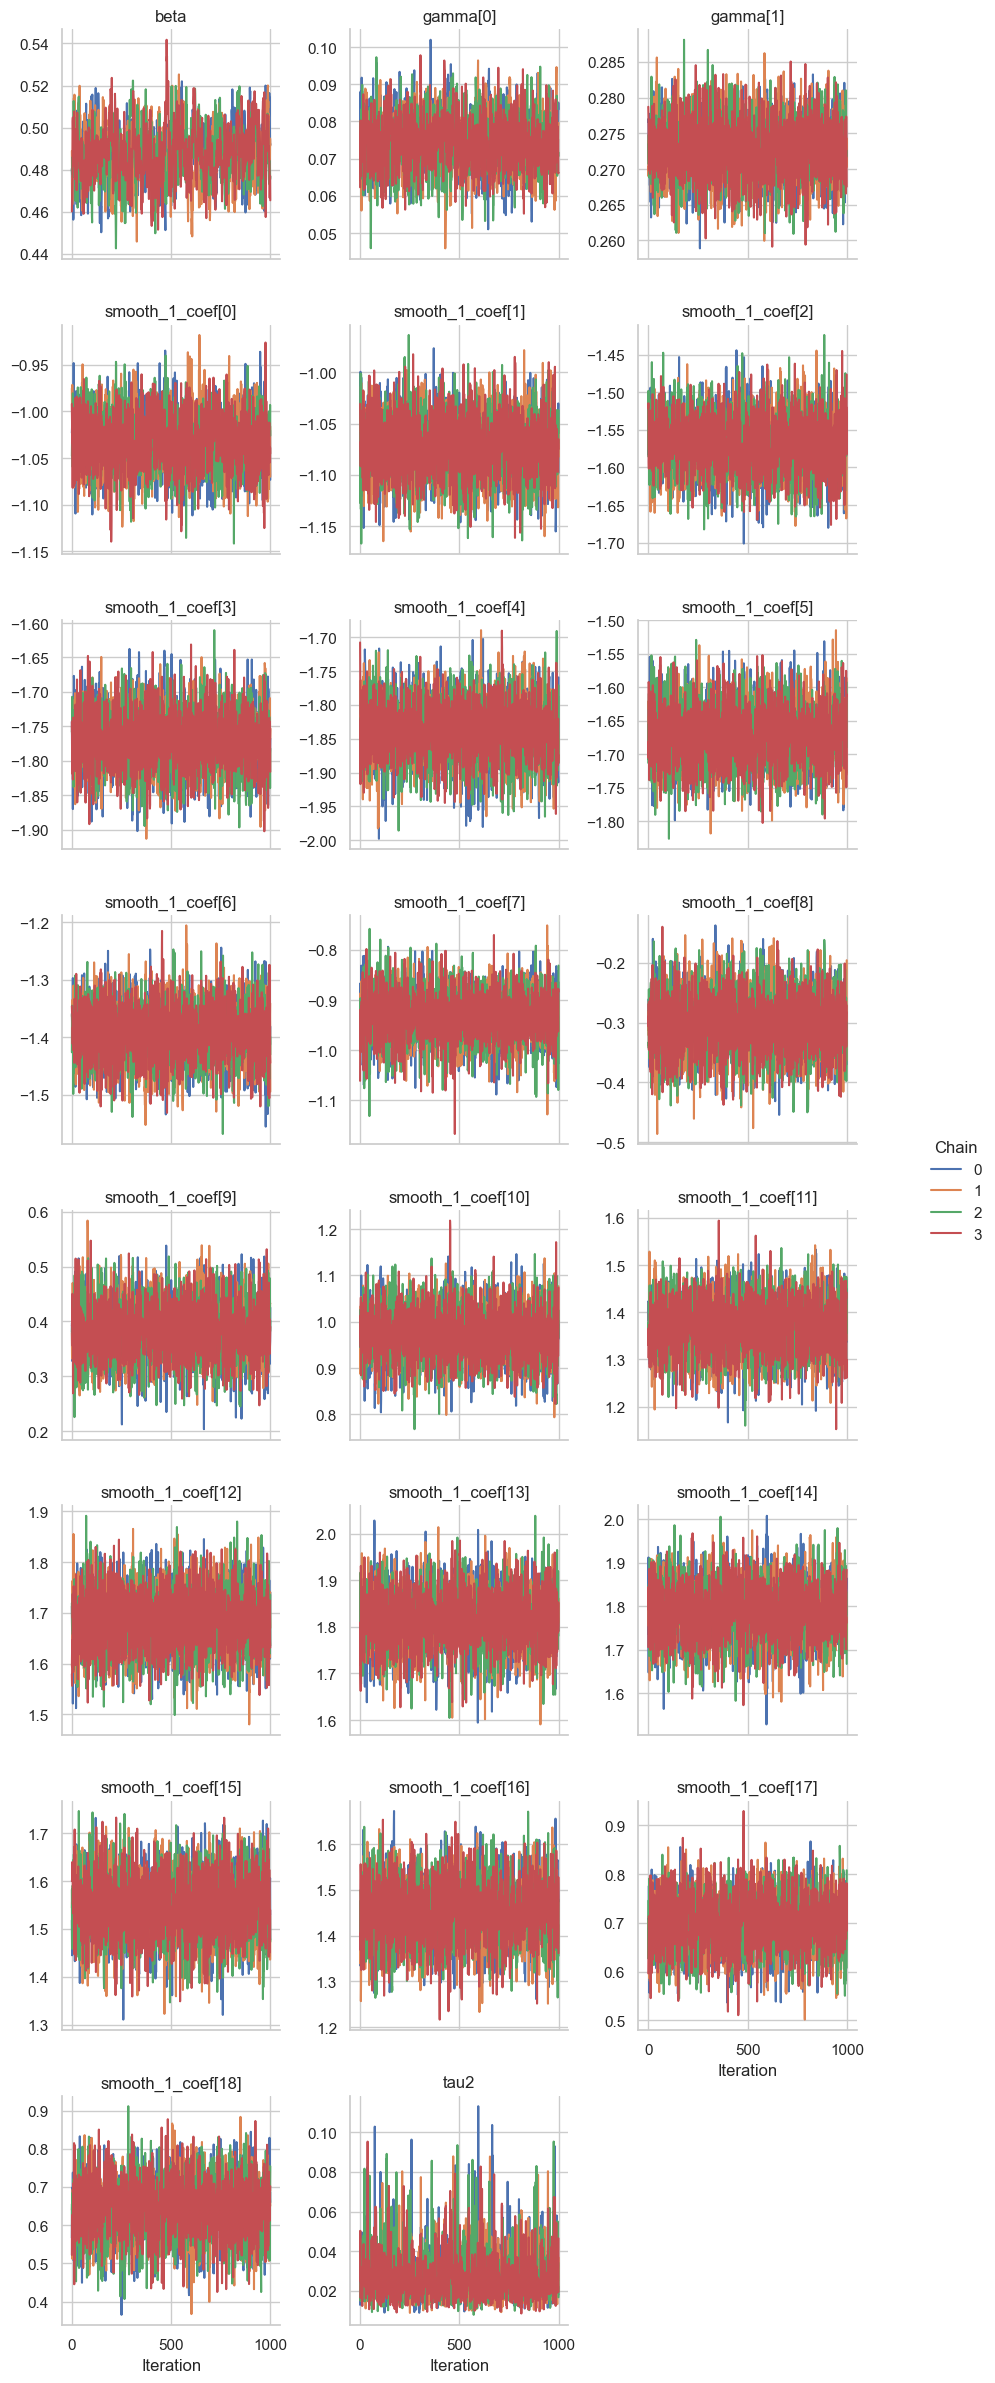

In [42]:
g = gs.plot_trace(results)

In [45]:
p = gs.Summary(results).quantities

In [46]:
p["mean"]

{'beta': array([0.487522], dtype=float32),
 'gamma': array([0.0745746, 0.2728167], dtype=float32),
 'smooth_1_coef': array([-1.0325311 , -1.072072  , -1.5687923 , -1.7691852 , -1.8375398 ,
        -1.6715059 , -1.3920193 , -0.9330892 , -0.30178124,  0.38436893,
         0.9713872 ,  1.369119  ,  1.6832236 ,  1.815416  ,  1.7869025 ,
         1.5467687 ,  1.4503204 ,  0.6996817 ,  0.6424069 ], dtype=float32),
 'tau2': array(0.0273158, dtype=float32)}

In [47]:
q.return_loc_params

{'beta': {'loc': Array([0.4927372], dtype=float32)},
 'tau2': {'loc': Array([0.03221947], dtype=float32)},
 'gamma': {'loc': Array([0.07460956, 0.26701406], dtype=float32)},
 'smooth1': {'loc': Array([-1.0376562 , -1.0422087 , -1.5959687 , -1.7495997 , -1.8280159 ,
         -1.6408622 , -1.356313  , -0.9325901 , -0.27474037,  0.3603594 ,
          0.9151003 ,  1.313791  ,  1.6588941 ,  1.8065054 ,  1.7888875 ,
          1.520319  ,  1.3628317 ,  0.66172034,  0.73542583], dtype=float32)}}

In [48]:
post_samples_liesel = results.get_posterior_samples()

## Comparison 

In [49]:
beta = p["mean"]["beta"]
smooth = p["mean"]["smooth_1_coef"]
gamma = p["mean"]["gamma"]
coef_loc = jnp.concatenate((beta, smooth))
y_loc = X.design_matrix @ coef_loc
y_scale = jnp.exp(Z.design_matrix @ gamma)

In [50]:
pred_data_lsl = pd.DataFrame({"x": x, "y_loc": y_loc, "y_scale": y_scale})
sort_pred_data_lsl = pred_data_lsl.sort_values("x")

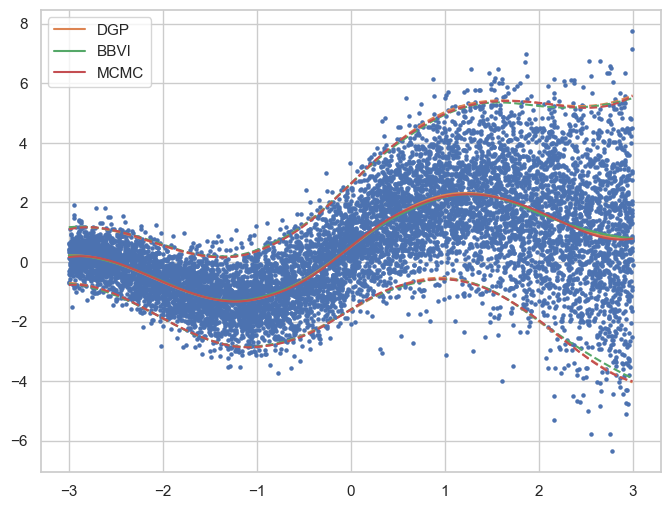

In [51]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=data["x"], y=data["y"], s=5)
plt.plot(data["x"], data["loc"], label="DGP", color=sns.color_palette()[1])
plt.plot(data["x"], data["loc"] + 1.96*data["scale"], color=sns.color_palette()[1], linestyle='dashed')
plt.plot(data["x"], data["loc"] - 1.96*data["scale"], color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"], color=sns.color_palette()[2], label = "BBVI")
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] + 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y_loc"] - 1.96*sort_pred_data_tiger["y_scale"], color=sns.color_palette()[2], linestyle='dashed')
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y_loc"], color=sns.color_palette()[3], label = "MCMC")
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y_loc"] + 1.96*sort_pred_data_lsl["y_scale"], color=sns.color_palette()[3], linestyle='dashed')
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y_loc"] - 1.96*sort_pred_data_lsl["y_scale"], color=sns.color_palette()[3], linestyle='dashed')
plt.legend()
plt.show()

sns.reset_orig()